In [1]:
import torch
from transformers import BertTokenizer, BertForMaskedLM, DataCollatorForLanguageModeling, Trainer, TrainingArguments

# Replace these lists with your actual dataset
# sentences = ["This is an example sentence from my domain.", "Another example sentence from my domain."]
from utils import load_train_eval_data

# Among the original training data, 75% is used for training, 25% is used for validation
train_prop = 0.75

## Hyperparameters 
# Set the fine-tuning type 
train_type = "sonnets" # One of ["sonnets", "shakestrain", "poems"]

multimodal = False
save_steps = 1
num_epochs = 3
lr = 5e-6

# Hyperparams for continue training with checkpoint 
continue_with_checkpoint = True
checkpoint_iter = 626 # Change this to change which checkpoint to load
num_finished_epochs = 2
num_finished_iter = 626



train_set, val_set = load_train_eval_data(train_type, multimodal, train_prop)



# if continue_with_checkpoint: 
#     checkpoint_iter = 15300 # Change this to change which checkpoint to load
#     num_remaining_epochs = 4
#     # Load the tokenizer and the pre-trained model
#     tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
#     model = BertForMaskedLM.from_pretrained(f"./results_prev/checkpoint-{checkpoint_iter}/")

#     # Set up the data collator
#     data_collator = DataCollatorForLanguageModeling(
#         tokenizer=tokenizer, mlm=True, mlm_probability=0.15
#     )
#     training_args = torch.load(f"./results_prev/checkpoint-{checkpoint_iter}/training_args.bin"),
#     print(list(training_args))
    
    
#     STOP
    
#     trainer = Trainer(
#         model=model,
#         args=training_args,
#         train_dataset=train_set,
#         eval_dataset=val_set,
#         data_collator=data_collator,
#     )
# else:
# Load the tokenizer and the pre-trained model

if train_type == "poems":
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    model = BertForMaskedLM.from_pretrained("bert-base-uncased")
elif train_type == "sonnets":
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    model = BertForMaskedLM.from_pretrained(f"./final_model_poems/")
elif train_type == "shakestrain":
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    model = BertForMaskedLM.from_pretrained(f"/final_model_sonnets/")
    
# Set up the data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

print(f"Training data type: {train_type}")

# Set up the training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    num_train_epochs=num_epochs,
    per_device_train_batch_size=100,
    logging_dir="./logs",
    logging_steps=1,
    save_steps=save_steps,
    seed=42,
    learning_rate=lr,
    weight_decay=0.01,
)

# Create the Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=val_set,
    data_collator=data_collator,
)
    
    
# Fine-tune the model
if continue_with_checkpoint:
    trainer.train(f"./results/checkpoint-{checkpoint_iter}/")
else:
    trainer.train()

torch.save(model, "model.pth")

Found cached dataset text (C:/Users/Shaobo Liang/.cache/huggingface/datasets/text/default-db0c42318206e9d0/0.0.0/cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at C:\Users\Shaobo Liang\.cache\huggingface\datasets\text\default-db0c42318206e9d0\0.0.0\cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2\cache-2cda8defa205abec.arrow
Loading cached processed dataset at C:\Users\Shaobo Liang\.cache\huggingface\datasets\text\default-db0c42318206e9d0\0.0.0\cb1e9bd71a82ad27976be3b12b407850fe2837d80c22c5e03a28949843a8ace2\cache-8579357d5cf86475.arrow


Training data type: sonnets


F:\Programs\anaconda3\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


0it [00:00, ?it/s]

Epoch,Training Loss,Validation Loss
3,2.919400,2.917797


In [2]:
output_dir = "./saved_model"
model.save_pretrained(output_dir)

In [3]:
from test import test_main
import json

# Print test results for the current saved model (last iteration)
model_path = "./saved_model/"

k = 5 # I want top 5 test metrics

results_dict = test_main(model_path, k)

print(f"Top {k} accuracy is {results_dict['accuracy']}.")
print(f"Top {k} cosine similarity score is {results_dict['cos_sim']}.")
# print(f"Top {k} rhyming score is {results_dict["rhyme"]}.") # To be implemented



# Obtain list of test results for eery checkpoint 
acc_arr = []
cos_arr = []

## Hyperparams 
prev_log_name = "acc_cos_log_lr5e-6_2epoch"
total_iters = 313

num_saved_models = int(total_iters * num_epochs / save_steps)
num_start_iter = num_finished_iter + save_steps  # The starting iteration of this training round here 

if continue_with_checkpoint:
    with open(f"./results/{prev_log_name}.json", "r") as openfile:
        json_object = json.load(openfile)
    acc_arr = json_object["acc_arr"]
    cos_arr = json_object["cos_arr"]
    
    for i in range(num_saved_models - num_start_iter):
        model_path = f"./results/checkpoint-{save_steps * (i + 1 + num_start_iter)}/"

        k = 5 # I want top 5 test metrics

        results_dict = test_main(model_path, k)

        print(f"Checkpoint {save_steps * (i+1+num_start_iter)}")
        print(f"Top {k} accuracy is {results_dict['accuracy']}.")
        print(f"Top {k} cosine similarity score is {results_dict['cos_sim']}.")

        acc_arr.append(results_dict['accuracy'])
        cos_arr.append(results_dict['cos_sim'])    
else:
    for i in range(num_saved_models):
        model_path = f"./results/checkpoint-{save_steps * (i + 1)}/"

        k = 5 # I want top 5 test metrics

        results_dict = test_main(model_path, k)

        print(f"Checkpoint {save_steps * (i+1)}")
        print(f"Top {k} accuracy is {results_dict['accuracy']}.")
        print(f"Top {k} cosine similarity score is {results_dict['cos_sim']}.")

        acc_arr.append(results_dict['accuracy'])
        cos_arr.append(results_dict['cos_sim'])
    


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


{'accuracy': 0.10455764075067024, 'cos_sim': tensor(0.3744)}
Top 5 accuracy is 0.22788203753351208.
Top 5 cosine similarity score is 0.5131357908248901.
Checkpoint 628
Top 5 accuracy is 0.2359249329758713.
Top 5 cosine similarity score is 0.517056405544281.
Checkpoint 629
Top 5 accuracy is 0.2359249329758713.
Top 5 cosine similarity score is 0.5169262886047363.
Checkpoint 630
Top 5 accuracy is 0.23324396782841822.
Top 5 cosine similarity score is 0.5151929259300232.
Checkpoint 631
Top 5 accuracy is 0.23324396782841822.
Top 5 cosine similarity score is 0.5150535702705383.
Checkpoint 632
Top 5 accuracy is 0.23324396782841822.
Top 5 cosine similarity score is 0.5149964094161987.
Checkpoint 633
Top 5 accuracy is 0.23324396782841822.
Top 5 cosine similarity score is 0.5152814388275146.
Checkpoint 634
Top 5 accuracy is 0.23324396782841822.
Top 5 cosine similarity score is 0.514980673789978.
Checkpoint 635
Top 5 accuracy is 0.23324396782841822.
Top 5 cosine similarity score is 0.5152570009231

Checkpoint 704
Top 5 accuracy is 0.2359249329758713.
Top 5 cosine similarity score is 0.5189383625984192.
Checkpoint 705
Top 5 accuracy is 0.2359249329758713.
Top 5 cosine similarity score is 0.5188860893249512.
Checkpoint 706
Top 5 accuracy is 0.2359249329758713.
Top 5 cosine similarity score is 0.5185074210166931.
Checkpoint 707
Top 5 accuracy is 0.2359249329758713.
Top 5 cosine similarity score is 0.5185075402259827.
Checkpoint 708
Top 5 accuracy is 0.2359249329758713.
Top 5 cosine similarity score is 0.5179687738418579.
Checkpoint 709
Top 5 accuracy is 0.2359249329758713.
Top 5 cosine similarity score is 0.5179687738418579.
Checkpoint 710
Top 5 accuracy is 0.2359249329758713.
Top 5 cosine similarity score is 0.5177775621414185.
Checkpoint 711
Top 5 accuracy is 0.2359249329758713.
Top 5 cosine similarity score is 0.5177760124206543.
Checkpoint 712
Top 5 accuracy is 0.2359249329758713.
Top 5 cosine similarity score is 0.5176842212677002.
Checkpoint 713
Top 5 accuracy is 0.23592493297

Checkpoint 782
Top 5 accuracy is 0.23324396782841822.
Top 5 cosine similarity score is 0.5167723894119263.
Checkpoint 783
Top 5 accuracy is 0.23324396782841822.
Top 5 cosine similarity score is 0.5167723298072815.
Checkpoint 784
Top 5 accuracy is 0.23324396782841822.
Top 5 cosine similarity score is 0.5168312191963196.
Checkpoint 785
Top 5 accuracy is 0.23324396782841822.
Top 5 cosine similarity score is 0.5161733031272888.
Checkpoint 786
Top 5 accuracy is 0.23324396782841822.
Top 5 cosine similarity score is 0.5161733031272888.
Checkpoint 787
Top 5 accuracy is 0.23324396782841822.
Top 5 cosine similarity score is 0.5161241888999939.
Checkpoint 788
Top 5 accuracy is 0.23324396782841822.
Top 5 cosine similarity score is 0.5161094069480896.
Checkpoint 789
Top 5 accuracy is 0.23324396782841822.
Top 5 cosine similarity score is 0.5164883732795715.
Checkpoint 790
Top 5 accuracy is 0.23324396782841822.
Top 5 cosine similarity score is 0.5162126421928406.
Checkpoint 791
Top 5 accuracy is 0.23

Checkpoint 859
Top 5 accuracy is 0.23324396782841822.
Top 5 cosine similarity score is 0.5157953500747681.
Checkpoint 860
Top 5 accuracy is 0.23324396782841822.
Top 5 cosine similarity score is 0.5157953500747681.
Checkpoint 861
Top 5 accuracy is 0.23324396782841822.
Top 5 cosine similarity score is 0.5157954692840576.
Checkpoint 862
Top 5 accuracy is 0.23324396782841822.
Top 5 cosine similarity score is 0.5157955288887024.
Checkpoint 863
Top 5 accuracy is 0.23324396782841822.
Top 5 cosine similarity score is 0.5158100724220276.
Checkpoint 864
Top 5 accuracy is 0.23324396782841822.
Top 5 cosine similarity score is 0.515866219997406.
Checkpoint 865
Top 5 accuracy is 0.23324396782841822.
Top 5 cosine similarity score is 0.515866219997406.
Checkpoint 866
Top 5 accuracy is 0.23324396782841822.
Top 5 cosine similarity score is 0.5158661603927612.
Checkpoint 867
Top 5 accuracy is 0.23324396782841822.
Top 5 cosine similarity score is 0.5158661007881165.
Checkpoint 868
Top 5 accuracy is 0.2332

Checkpoint 936
Top 5 accuracy is 0.22788203753351208.
Top 5 cosine similarity score is 0.5131357908248901.
Checkpoint 937
Top 5 accuracy is 0.22788203753351208.
Top 5 cosine similarity score is 0.5131357908248901.
Checkpoint 938
Top 5 accuracy is 0.22788203753351208.
Top 5 cosine similarity score is 0.5131357908248901.
Checkpoint 939
Top 5 accuracy is 0.22788203753351208.
Top 5 cosine similarity score is 0.5131357908248901.


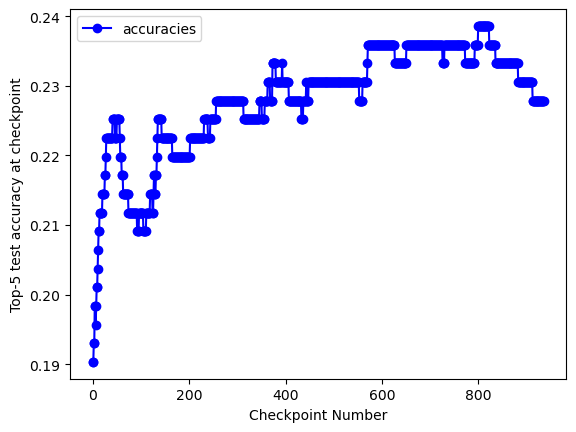

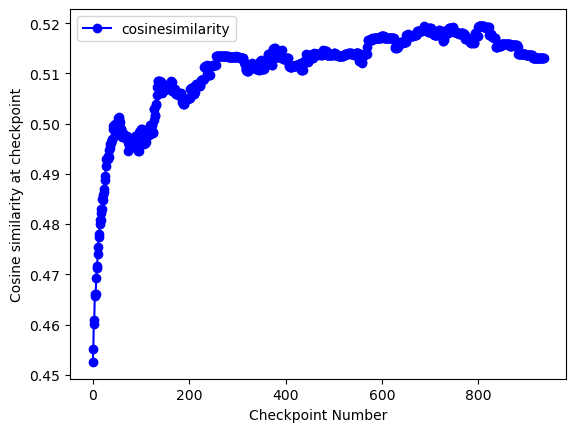

In [4]:
import matplotlib
import matplotlib.pyplot as plt

plt.plot(acc_arr, '-o', label = 'accuracies', color = 'blue')
plt.xlabel('Checkpoint Number')
plt.ylabel('Top-5 test accuracy at checkpoint')
plt.legend()
plt.show()

plt.plot(cos_arr, '-o', label = 'cosinesimilarity', color = 'blue')
plt.xlabel('Checkpoint Number')
plt.ylabel('Cosine similarity at checkpoint')
plt.legend()
plt.show()

In [5]:
# Save log to text file

array_log = open("acc_cos_log.txt", "w")

array_log.write(str(acc_arr))
array_log.write(str("\n\n"))
array_log.write(str(cos_arr))

array_log.close()

In [6]:
# Save log to json file

import json

cos_arr_list = []

# if continue_with_checkpoint:
for i in range(len(cos_arr)):
    if type(cos_arr[i]) == float:
        cos_arr_list.append(cos_arr[i])
    else:
        cos_arr_list.append(cos_arr[i].item())
# else: 
#     for i in range(len(cos_arr)):
#         cos_arr_list.append(cos_arr[i].item())
    
arrays_dict = {
    "acc_arr": acc_arr,
    "cos_arr": cos_arr_list
}

json_object = json.dumps(arrays_dict)

with open("acc_cos_log.json", "w") as outfile:
    outfile.write(json_object)

In [12]:
max_acc = 0
num_max_acc_iter = 0
max_cos = 0
num_max_cos_iter = 0

for i in range(len(acc_arr)):
    if acc_arr[i] > max_acc:
        max_acc = acc_arr[i]
        num_max_acc_iter = save_steps * (i + 1)
    if cos_arr[i] > max_cos:
        max_cos = cos_arr[i]
        num_max_cos_iter = save_steps * (i + 1)

if acc_arr[num_max_acc_iter-1] == acc_arr[num_max_cos_iter-1]:
    num_max_acc_iter = num_max_cos_iter
        
print(f"Max Acc: {max_acc}")
print(f"Max Acc Iter: {num_max_acc_iter}")
print()
print(f"Max Cos: {max_cos}")
print(f"Max Cos Iter: {num_max_cos_iter}")

Max Acc: 0.2386058981233244
Max Acc Iter: 811

Max Cos: 0.5194487571716309
Max Cos Iter: 811
